<h1>Cell classification with supervised models</h1>

In [2]:
import sys
if '/home/rossco/immunova' not in sys.path:
    sys.path.append('/home/rossco/immunova')
from immunova.data.mongo_setup import pd_init
from immunova.data.fcs_experiments import FCSExperiment
from immunova.flow.gating.actions import Gating
from immunova.flow.gating.defaults import ChildPopulationCollection
from immunova.flow.supervised.cell_classifier import create_reference_sample
from warnings import filterwarnings
from tqdm import tqdm_notebook
import matplotlib
import pandas as pd
import os
filterwarnings('ignore')
pd_init()

In [3]:
texp = FCSExperiment.objects(experiment_id='PD_T_PDMCs').get()

In [4]:
exclude = [f'{x}_pdmc_t' for x in ['209-03', '210-14', '273-01', '298-01', '322-01', '237-06', '302-01']]

In [8]:
create_reference_sample(experiment=texp,
                        root_population='single_Live_CD3+',
                        exclude=exclude,
                        sample_n=30000)

-------------------- Generating Reference Sample --------------------
Finding features common to all fcs files...
Sampling 142-09_pdmc_t...
Sampling 165-09_pdmc_t...
Sampling 175-09_pdmc_t...
Sampling 209-05_pdmc_t...
Sampling 239-02_pdmc_t...
Sampling 239-04_pdmc_t...
Sampling 251-07_pdmc_t...
Sampling 251-08_pdmc_t...
Sampling 254-04_pdmc_t...
Sampling 254-05_pdmc_t...
Sampling 255-04_pdmc_t...
Sampling 255-05_pdmc_t...
Sampling 264-02_pdmc_t...
Sampling 267-02_pdmc_t...
Sampling 276-01_pdmc_t...
Sampling 286-03_pdmc_t...
Sampling 286-04_pdmc_t...
Sampling 294-02_pdmc_t...
Sampling 294-03_pdmc_t...
Sampling 305-01_pdmc_t...
Sampling 305-03_pdmc_t...
Sampling 306-01_pdmc_t...
Sampling 308-02R_pdmc_t...
Sampling 308-03R_pdmc_t...
Sampling 308-04_pdmc_t...
Sampling 310-01_pdmc_t...
Sampling 315-01_pdmc_t...
Sampling 315-02_pdmc_t...
Sampling 318-01_pdmc_t...
Sampling 323-01_pdmc_t...
Sampling 324-01_pdmc_t...
Sampling 326-01_pdmc_t...
Sampling 267-01_pdmc_t...
Sampling 279-03_pdmc_t...


<h2>Gate the sampled data</h2>

We have a sampled dataset, a concatination of the 43 PDMC samples. I will now label this dataset to be used as training data for a supervised machine learning model that will perform multi-label classification of cells.

In [5]:
sample = Gating(texp, 'PD_T_PDMCs_sampled_data', include_controls=False)

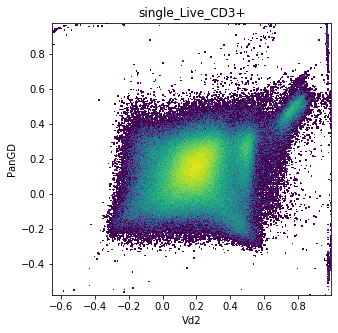

In [10]:
sample.plotting.plot_population('single_Live_CD3+', 'Vd2', 'PanGD', transforms={'x': 'logicle', 
                                                                                'y': 'logicle'})

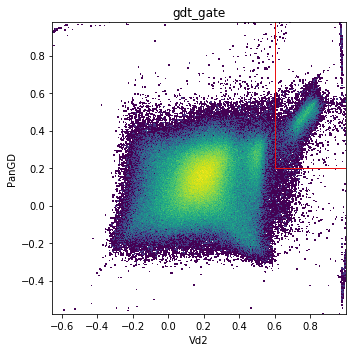

In [11]:
children = ChildPopulationCollection('geom')
children.add_population('gdt', definition='+')
children.add_population('nongdt', definition='-')
kwargs = dict(x='Vd2', y='PanGD', transform_x='logicle', transform_y='logicle',
             x_min=0.6, y_min=0.2, x_max=1, y_max=1)
sample.create_gate(gate_name='gdt_gate', 
                   parent='single_Live_CD3+',
                   class_='Static',
                   method='rect_gate',
                   child_populations=children, 
                   kwargs=kwargs)
sample.apply('gdt_gate')

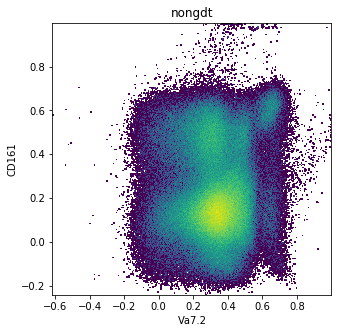

In [12]:
sample.plotting.plot_population('nongdt', 'Va7.2', 'CD161', transforms={'x': 'logicle', 'y': 'logicle'})

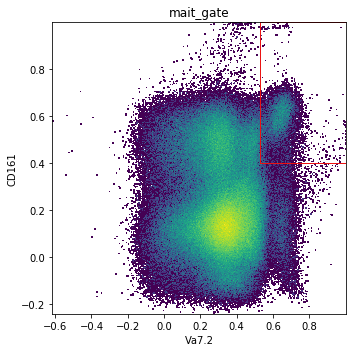

In [13]:
children = ChildPopulationCollection('geom')
children.add_population('mait', definition='+')
children.add_population('classic', definition='-')
kwargs = dict(x='Va7.2', y='CD161', transform_x='logicle', transform_y='logicle',
             x_min=0.53, y_min=0.4, x_max=1, y_max=1)
sample.create_gate(gate_name='mait_gate', 
                   parent='nongdt',
                   class_='Static',
                   method='rect_gate',
                   child_populations=children, 
                   kwargs=kwargs)
sample.apply('mait_gate')

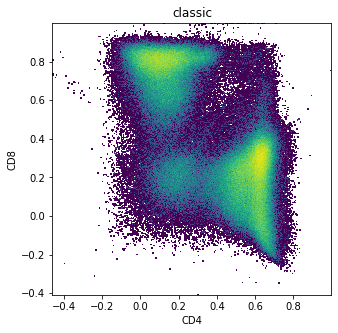

In [14]:
sample.plotting.plot_population('classic', 'CD4', 'CD8', transforms={'x': 'logicle', 'y': 'logicle'})

In [15]:
children = ChildPopulationCollection('threshold_2d')
children.add_population('CD4+CD8+', definition='++')
children.add_population('CD4-CD8-', definition='--')
children.add_population('CD4+CD8-', definition='+-')
children.add_population('CD4-CD8+', definition='-+')
kwargs = dict(x='CD4', y='CD8', transform_x='logicle', transform_y='logicle',
             threshold_x=0.42, threshold_y=0.55)
sample.create_gate(gate_name='cd4cd8_gate', 
                   parent='classic',
                   class_='Static',
                   method='threshold_2d',
                   child_populations=children, 
                   kwargs=kwargs)

True

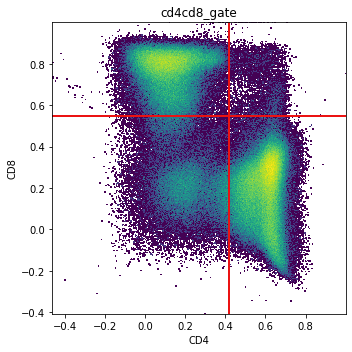

In [16]:
sample.apply('cd4cd8_gate')

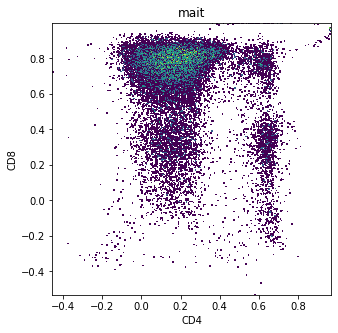

In [17]:
sample.plotting.plot_population('mait', 'CD4', 'CD8', transforms={'x': 'logicle', 'y': 'logicle'})

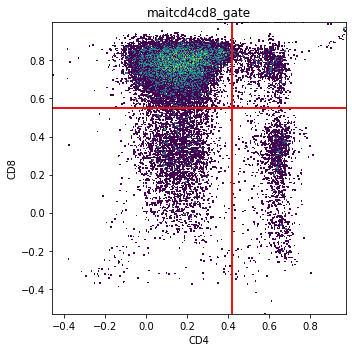

In [18]:
children = ChildPopulationCollection('threshold_2d')
children.add_population('mait+CD4+CD8+', definition='++')
children.add_population('mait+CD4-CD8-', definition='--')
children.add_population('mait+CD4+CD8-', definition='+-')
children.add_population('mait+CD4-CD8+', definition='-+')
kwargs = dict(x='CD4', y='CD8', transform_x='logicle', transform_y='logicle',
             threshold_x=0.42, threshold_y=0.55)
sample.create_gate(gate_name='maitcd4cd8_gate', 
                   parent='mait',
                   class_='Static',
                   method='threshold_2d',
                   child_populations=children, 
                   kwargs=kwargs)
sample.apply('maitcd4cd8_gate')

In [19]:
sample.save(overwrite=True)

Saved successfully!


True

<h2>Label a sample for validation</h2>

In [5]:
val = Gating(texp, '267-02_pdmc_t')

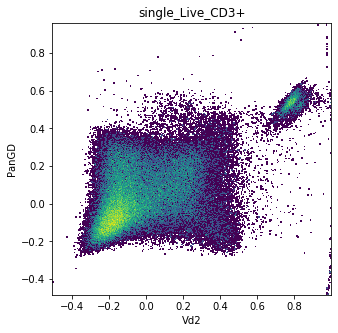

In [17]:
val.plotting.plot_population('single_Live_CD3+', 'Vd2', 'PanGD', transforms={'x': 'logicle',
                                                                             'y': 'logicle'})

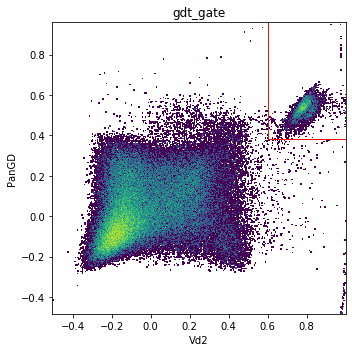

In [18]:
children = ChildPopulationCollection('geom')
children.add_population('gdt', definition='+')
children.add_population('nongdt', definition='-')
kwargs = dict(x='Vd2', y='PanGD', transform_x='logicle', transform_y='logicle',
             x_min=0.6, y_min=0.38, x_max=1, y_max=1)
val.create_gate(gate_name='gdt_gate', 
                parent='single_Live_CD3+',
                class_='Static',
                method='rect_gate',
                child_populations=children, 
                kwargs=kwargs)
val.apply('gdt_gate')

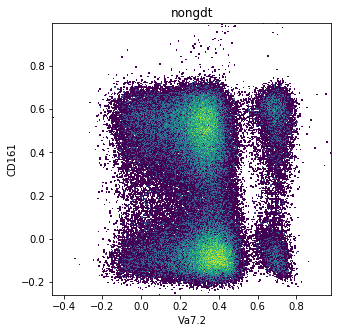

In [19]:
val.plotting.plot_population('nongdt', 'Va7.2', 'CD161', transforms={'x': 'logicle',
                                                                     'y': 'logicle'})

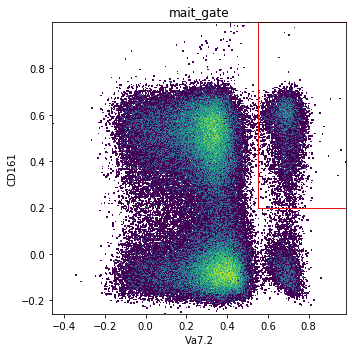

In [20]:
children = ChildPopulationCollection('geom')
children.add_population('mait', definition='+')
children.add_population('classic', definition='-')
kwargs = dict(x='Va7.2', y='CD161', transform_x='logicle', transform_y='logicle',
             x_min=0.55, y_min=0.2, x_max=1, y_max=1)
val.create_gate(gate_name='mait_gate', 
                parent='nongdt',
                class_='Static',
                method='rect_gate',
                child_populations=children, 
                kwargs=kwargs)
val.apply('mait_gate')

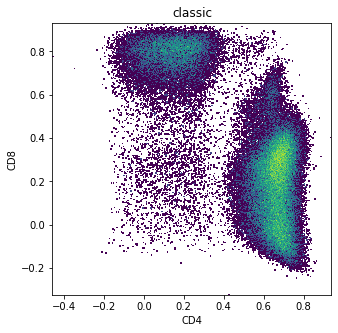

In [21]:
val.plotting.plot_population('classic', 'CD4', 'CD8', transforms={'x': 'logicle',
                                                                  'y': 'logicle'})

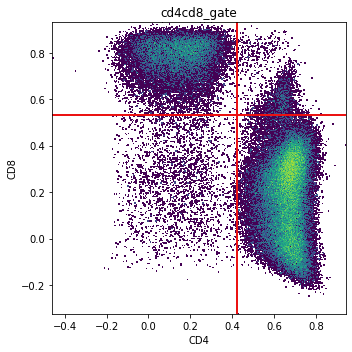

In [22]:
children = ChildPopulationCollection('threshold_2d')
children.add_population('CD4+CD8+', definition='++')
children.add_population('CD4-CD8-', definition='--')
children.add_population('CD4+CD8-', definition='+-')
children.add_population('CD4-CD8+', definition='-+')
kwargs = dict(x='CD4', y='CD8', transform_x='logicle', transform_y='logicle',
             threshold_x=0.42, threshold_y=0.53)
val.create_gate(gate_name='cd4cd8_gate', 
                parent='classic',
                class_='Static',
                method='threshold_2d',
                child_populations=children, 
                kwargs=kwargs)
val.apply('cd4cd8_gate')

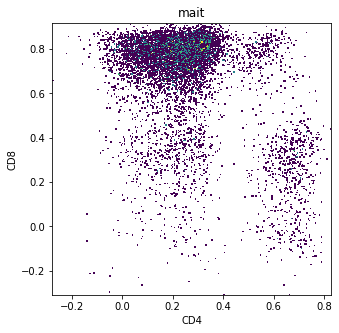

In [23]:
val.plotting.plot_population('mait', 'CD4', 'CD8', transforms={'x': 'logicle',
                                                                  'y': 'logicle'})

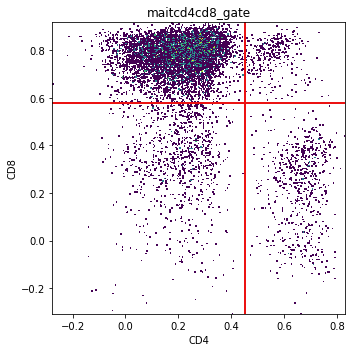

In [24]:
children = ChildPopulationCollection('threshold_2d')
children.add_population('mait+CD4+CD8+', definition='++')
children.add_population('mait+CD4-CD8-', definition='--')
children.add_population('mait+CD4+CD8-', definition='+-')
children.add_population('mait+CD4-CD8+', definition='-+')
kwargs = dict(x='CD4', y='CD8', transform_x='logicle', transform_y='logicle',
             threshold_x=0.45, threshold_y=0.58)
val.create_gate(gate_name='maitcd4cd8_gate', 
                parent='mait',
                class_='Static',
                method='threshold_2d',
                child_populations=children, 
                kwargs=kwargs)
val.apply('maitcd4cd8_gate')

In [25]:
val.save(overwrite=True)

Saved successfully!


True

<h2>Supervised learning</h2>

In [5]:
from immunova.flow.supervised.discriminant_analysis import DiscriminantAnalysis
from immunova.flow.supervised.svm import SupportVectorMachine
from immunova.flow.supervised.xgboost import XGBoostClassifier
from immunova.flow.supervised.deep_gating import DeepGating
from immunova.flow.supervised.knn import KNN

In [6]:
population_labels = ['gdt', 'nongdt', 'mait', 'classic', 'CD4+CD8+',
                    'CD4+CD8-', 'CD4-CD8+', 'CD4-CD8-', 'mait+CD4+CD8+',
                    'mait+CD4+CD8-', 'mait+CD4-CD8+', 'mait+CD4-CD8-']

In [7]:
features = ['Va7.2', 'SSC-A', 'PanGD', 'CD8', 'FSC-A', 'CD27', 'CCR7',
            'CXCR3', 'CD45RA', 'Vd2', 'FSC-H', 'CD161', 'SSC-W', 'CD4']

In [8]:
xgb = XGBoostClassifier(experiment=texp, reference_sample='PD_T_PDMCs_sampled_data',
                        population_labels=population_labels, transform='logicle',
                        features=features, root_population='single_Live_CD3+')

Constructing cell classifier object...
Loading information on reference sample...
Preparing training data and labels...
Scaling data...
Ready for training!


In [9]:
xgb.build_model(nthread=4)

In [10]:
holdout_performance = xgb.train_holdout(holdout_frac=0.3)

In [11]:
holdout_performance

,f1_score,accuracy,precision,recall,test_train
0,0.999953,0.999953,0.999953,0.999953,test
0,1.000000,1.000000,1.000000,1.000000,train


<h3>Debug indexing</h3>

In [12]:
val = Gating(texp, '267-02_pdmc_t')

In [13]:
data = val.get_population_df('single_Live_CD3+',
                             transform=True,
                             transform_method='logicle')[features]

In [14]:
idx = data.index
transformed_data = xgb.preprocessor.fit_transform(data)

In [15]:
transformed_data = pd.DataFrame(transformed_data, columns=features)
transformed_data.index = idx

In [16]:
len(val.populations['gdt'].index)

7755

In [18]:
import numpy as np
from immunova.flow.supervised.utilities import predict_class
y_probs = xgb.classifier.predict_proba(transformed_data.values)
y_hat = np.array(predict_class(y_probs))

In [20]:
pred, pro = xgb.manual_validation(sample_id='267-02_pdmc_t', return_probs=True)

In [21]:
y_hat = np.array(predict_class(pred))

In [22]:
transformed_data['prediction'] = y_hat

In [23]:
transformed_data

,Va7.2,SSC-A,PanGD,CD8,FSC-A,CD27,CCR7,CXCR3,CD45RA,Vd2,FSC-H,CD161,SSC-W,CD4,prediction
11,0.482911,1.173357,0.914703,-0.763687,0.091460,-0.836120,0.010556,0.724242,0.042119,-0.635752,0.052466,1.012188,-0.027433,0.645171,2
18,0.330542,-0.735020,-0.864681,-0.877091,1.199549,-0.995029,-0.100448,0.416714,-0.069721,-0.875494,1.325021,0.589740,-0.827876,0.767913,2
27,0.098945,-0.760028,0.236873,0.123452,0.690429,1.124044,-2.092273,-0.532889,-0.258997,-0.439214,0.911632,-1.430201,-0.860623,0.693669,2
54,-2.656060,-0.913904,2.853156,0.023751,-1.077713,0.329033,-1.297836,-1.366689,-0.014201,3.187635,-0.712448,-1.425244,-1.094398,-1.826441,8
74,-1.129014,-0.661981,0.336799,-0.835783,0.250825,0.209981,0.527824,-0.397861,-0.838953,-0.604010,0.514050,0.029451,-2.113752,0.403412,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3394421,0.089924,-1.287617,0.284520,-0.968012,-0.704600,0.293363,-0.946476,-0.309847,1.901976,1.228832,-0.477261,0.864704,-0.238889,-1.257024,0
3394430,-1.359445,0.927835,1.094402,0.247496,0.737856,-0.122125,-0.266700,-0.427588,-1.598748,-0.832447,0.511799,-1.419348,0.282314,0.864959,2
3394432,-0.025628,-0.919140,0.167949,-1.412158,0.493327,-1.451413,-0.724878,-0.334296,-0.711567,-0.739285,0.549385,0.589774,0.653064,0.670194,2
3394434,0.494312,0.660288,0.005602,0.179841,0.069171,1.211947,0.834274,0.162918,-0.538359,-0.785896,-0.056012,0.691541,1.203808,0.711018,2


In [30]:
parent = val.get_population_df(population_name='single_Live_CD3+')
new_populations = ChildPopulationCollection(gate_type='sml')
for i, pops in xgb.mappings.items():
    y_ = np.where(y_hat == i)
    idx = val.populations['single_Live_CD3+'].index[y_]
    for p in pops:
        if p not in new_populations.populations.keys():
            new_populations.add_population(name=p)
            new_populations.populations[p].update_geom(shape='sml', x=None, y=None)
        new_populations.populations[p].update_index(idx)

In [44]:
len(val.populations['gdt'].index)

7755

In [47]:
[x for x in val.populations['gdt'].index
 if x not in np.array(new_populations.populations['gdt'].index, dtype=np.int)]

[]

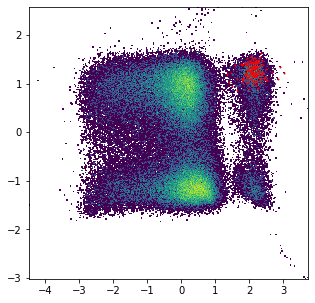

In [76]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
fig, ax = plt.subplots(figsize=(5,5))
ax.hist2d(transformed_data['Va7.2'], transformed_data['CD161'], bins=500, norm=LogNorm())
gdt = transformed_data[transformed_data.prediction == 7]
ax.scatter(gdt['Va7.2'], gdt['CD161'], s=1, c='r')
fig.show()

<h3>Debug backgate</h3>

In [32]:
val = xgb.predict('267-02_pdmc_t')

In [33]:
val.print_population_tree()

root
├── cells
│   ├── CD3+
│   │   ├── dead
│   │   └── live
│   │       ├── singlets1
│   │       │   ├── single_Live_CD3+
│   │       │   │   ├── gdt
│   │       │   │   ├── nongdt
│   │       │   │   │   ├── mait
│   │       │   │   │   │   ├── mait+CD4+CD8+
│   │       │   │   │   │   ├── mait+CD4-CD8-
│   │       │   │   │   │   ├── mait+CD4+CD8-
│   │       │   │   │   │   └── mait+CD4-CD8+
│   │       │   │   │   └── classic
│   │       │   │   │       ├── CD4+CD8+
│   │       │   │   │       ├── CD4-CD8-
│   │       │   │   │       ├── CD4+CD8-
│   │       │   │   │       └── CD4-CD8+
│   │       │   │   ├── XGBoost_gdt
│   │       │   │   ├── XGBoost_nongdt
│   │       │   │   ├── XGBoost_mait
│   │       │   │   ├── XGBoost_classic
│   │       │   │   ├── XGBoost_CD4+CD8+
│   │       │   │   ├── XGBoost_CD4+CD8-
│   │       │   │   ├── XGBoost_CD4-CD8+
│   │       │   │   ├── XGBoost_CD4-CD8-
│   │       │   │   ├── XGBoost_mait+CD4+CD8+
│   │       │   │   ├── XGBoost_mait+

In [21]:
y_hat, peformance = xgb.manual_validation('267-02_pdmc_t', return_probs=True)

In [22]:
from immunova.flow.supervised.utilities import predict_class
y_hat = predict_class(y_hat)

In [25]:
import numpy as np
y_hat = np.array(y_hat)

In [26]:
population_labels

['gdt',
 'nongdt',
 'mait',
 'classic',
 'CD4+CD8+',
 'CD4+CD8-',
 'CD4-CD8+',
 'CD4-CD8-',
 'mait+CD4+CD8+',
 'mait+CD4+CD8-',
 'mait+CD4-CD8+',
 'mait+CD4-CD8-']

In [31]:
parent = val.get_population_df('single_Live_CD3+')
new_populations = ChildPopulationCollection(gate_type='sml')

In [34]:
for i, label in enumerate(population_labels):
    label = f'XGBoost_{label}'
    y_ = np.where(y_hat == i)
    idx = val.populations['single_Live_CD3+'].index[y_]
    new_populations.add_population(name=label)
    new_populations.populations[label].update_index(idx)
    new_populations.populations[label].update_geom(shape='sml', x=None, y=None)

In [42]:
val.update_populations(new_populations, parent, parent_name='single_Live_CD3+', warnings=[])

In [56]:
val.populations['gdt'].index

array([     54,    1663,    2389, ..., 3393460, 3393615, 3394193])

In [62]:
val.populations['single_Live_CD3+'].index

array([     11,      18,      27, ..., 3394432, 3394434, 3394449])

In [58]:
np.where(y_hat == 0)

(array([    25,     26,     30, ..., 178977, 178987, 178996]),)

In [53]:
val.get_population_df('XGBoost_gdt').shape

(11543, 19)

In [28]:
import matplotlib.pyplot as plt
from matplotlib import cm
plt.get_cmap('tab20')

In [32]:
cm.cmap_d['tab20'].colors

((0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (0.6823529411764706, 0.7803921568627451, 0.9098039215686274),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (1.0, 0.7333333333333333, 0.47058823529411764),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.596078431372549, 0.8745098039215686, 0.5411764705882353),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (1.0, 0.596078431372549, 0.5882352941176471),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.7725490196078432, 0.6901960784313725, 0.8352941176470589),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.7686274509803922, 0.611764705882353, 0.5803921568627451),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.9686274509803922, 0.7137254901960784, 0.8235294117647058),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7803921568627451, 0.7803921568627451, 0.7803921568627451),
 (0.7372549019607844, 0.74117647

In [14]:
root_population='single_Live_CD3+'
x='Vd2'
y='PanGD'
populations=['XGBoost_gdt']
transforms=None

In [15]:
# Check populations exist
for p in [root_population] + populations:
    if p not in val.populations.keys():
        print(f'Error: could not find {p} in associated gatting object')

In [16]:
# Check root population is upstream
for p in populations:
    dependencies = val.find_dependencies(p)
    if root_population in dependencies:
        print(f'Error: population {p} is upstream from the chosen root population {root_population}')

In [17]:
# Establish axis vars and transforms
axes_vars = {'x': x, 'y': y}
if transforms is None:
    transforms = dict(x='logicle', y='logicle')
    for a in ['x', 'y']:
        if any([x in axes_vars[a] for x in ['FSC', 'SSC']]):
            transforms[a] = None

In [18]:
transforms

{'x': 'logicle', 'y': 'logicle'}

In [19]:
from scipy.spatial import ConvexHull
from immunova.flow.gating.plotting.static_plots import transform_axes

In [20]:
# Collect data and build polygons
def poly_cords(pdata):
    v = ConvexHull(pdata).vertices
    return pdata[v[0], 0], pdata[v[1], 1]

In [21]:
root_data = transform_axes(val.get_population_df(root_population),
                           transforms=transforms, axes_vars=axes_vars)
pop_data = {p: transform_axes(val.get_population_df(p),
                              axes_vars, transforms)
            for p in populations}

In [23]:
pop_hull = {p: poly_cords(d.values) for p, d in pop_data.items()}

In [ ]:
pop_hull = {p: poly_cords(d.values) for p, d in pop_data.items()}
pop_centroids = {p: centroid(d.values) for p, d in pop_data.items()}

# Build plotting constructs
if title is None:
    title = f'{root_population}: {populations}'
fig, ax = plt.subplots(figsize=(8,8))
ax = self.__2dhist(ax=ax, data=root_data, x=x, y=y)
ax = self.__plot_asthetics(ax, x, y, xlim, ylim, title)
for p, c in zip(pop_data.keys(), plt.get_cmap('tab20')):
    ax.plot(pop_hull[p][0], pop_hull[p][1], '-k', c='r', label=p)
    ax.scatter(x=pop_centroids[p][0], y=pop_centroids[p][0], s=25, c=[c],
               linewidth=1, edgecolors='black', label=p)
ax.legend()